In [2]:
# Import 
import pandas as pd 
import numpy as np
import mne
import matplotlib.pyplot as plt 
from scipy.fft import rfft, rfftfreq

# Handle sys PATH
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
# Import dataset - DREAM 
df = pd.read_csv("../../dataset/DREAM/Datasets.csv", index_col=0)
rec_df = pd.read_csv("../../dataset/DREAM/Data records.csv", index_col=0)
people_df = pd.read_csv("../../dataset/DREAM/People.csv")

file = "../../dataset/DREAM/Zhang & Wamsley 2019/Data/PSG/subject026_Morning.edf"
data = mne.io.read_raw_edf(file)
dream_df = data.get_data()

# Metadata 
info = data.info
channels = data.ch_names
raw_df = pd.DataFrame(dream_df)
raw_df.index = channels

Extracting EDF parameters from /Users/alicialarsen/Documents/TUe/Honors/MedAI/TUe-Honors-MedAI/dataset/DREAM/Zhang & Wamsley 2019/Data/PSG/subject026_Morning.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


In [4]:
# Record info
rec_df \
    .loc[rec_df.Filename == "subject026_Morning.edf"] \
    .iloc[0];

#### 1. Multitaper spectral analysis 

Decompose the raw EEG data in DREAM dataset into spectrogram similar to the PhysioNet dataset SDB. 
1. Divide into 2s epoch - Be aware of the sampling rate
2. Appy multitaper spectral analysis to drive spectrogram of 0.5 Hz band between 0 Hz and 100 Hz for each window of 2s (epoch)

In [5]:
# Filter 
eeg_df = raw_df.loc["Fp1-REF"].copy().values
sample_df = eeg_df[:800] # Get first epoch of 2s 

In [6]:
def dB(X):
    return 10 * np.log10(X)

In [7]:
# Internal import 
from signal_analysis.feature_extraction import *

ModuleNotFoundError: No module named 'signal_analysis'

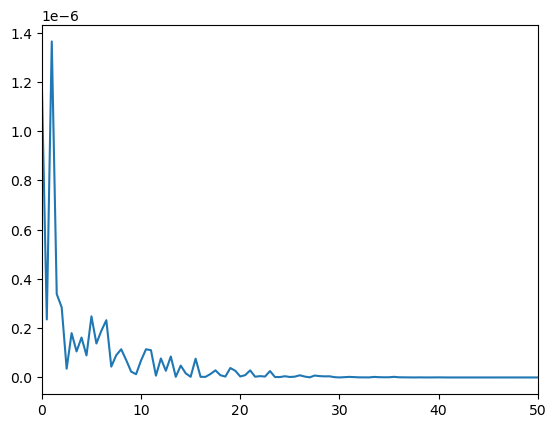

In [7]:
# Fourier Transform to frequency domain
ft_transform = FourierTransform(400, 0.5)
ft_output, freq_bin = ft_transform.transform(sample_df, 2)
y = np.square(ft_output)
plt.plot(freq_bin, y)
plt.xlim(0, 50)
plt.show()

In [8]:
freq_bin[freq_bin <= 50].shape

(101,)

Now we do Multitapered spectral analysis which is an improved version of the FT using the mne package. The improvements are:

In [9]:
# Import mne
from mne.time_frequency import psd_array_multitaper

    Using multitaper spectrum estimation with 7 DPSS windows


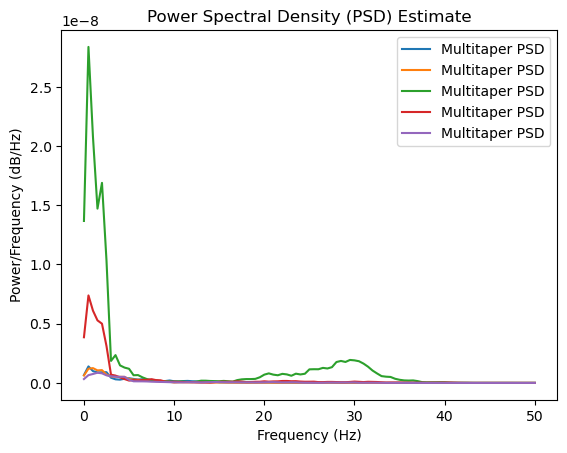

In [10]:
# Calculate power spectral density (PSD) using multitaper method (Sample)
n = len(eeg_df)
n_sample = (n // 800) * 800
X = eeg_df[:n_sample].reshape(n // 800, 800)

psds, freqs = psd_array_multitaper(X, sfreq=400, fmin=0, fmax=50, n_jobs=1, output="power")
plt.figure()
plt.plot(freqs, psds[0:5].T, label='Multitaper PSD')
plt.title('Power Spectral Density (PSD) Estimate')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power/Frequency (dB/Hz)')
plt.legend()
plt.show()

In [27]:
# Define Multitaper method function 
def multitaper_spectral_analysis(sample, fs=400, fmin=0, fmax=50, epoch_size=2, f_res=0.5):
    n = len(sample)
    n_per_epoch = epoch_size * fs 
    n_epoch = (n // n_per_epoch)
    X = sample[:n_epoch * n_per_epoch].reshape(n // n_per_epoch, n_per_epoch)

    psds, freqs = psd_array_multitaper(X, fs, fmin=fmin, fmax=fmax, n_jobs=1, output="power")

    return psds, freqs


psds, freqs = multitaper_spectral_analysis(eeg_df)

df_data = pd.DataFrame(data=psds, columns=freqs)
df_data

    Using multitaper spectrum estimation with 7 DPSS windows


,0.0,0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,...,45.5,46.0,46.5,47.0,47.5,48.0,48.5,49.0,49.5,50.0
0,6.639733e-10,1.393382e-09,9.963022e-10,8.880629e-10,8.987017e-10,9.080956e-10,4.404667e-10,3.040769e-10,2.768109e-10,3.523393e-10,...,4.715347e-14,3.129768e-14,4.118011e-14,4.563374e-14,4.568202e-14,4.249045e-14,4.536025e-14,5.449415e-14,4.712193e-14,4.272813e-14
1,6.262015e-10,1.202748e-09,1.248772e-09,1.056382e-09,1.081547e-09,6.983448e-10,5.508345e-10,5.190399e-10,5.131298e-10,5.038673e-10,...,2.352322e-14,2.026584e-14,1.387592e-14,1.988960e-14,1.551844e-14,1.364923e-14,1.103566e-14,1.072484e-14,8.704010e-15,6.878939e-15
2,1.367621e-08,2.837236e-08,2.077293e-08,1.471802e-08,1.689398e-08,1.033605e-08,1.857547e-09,2.348926e-09,1.481665e-09,1.295006e-09,...,2.345886e-12,3.593632e-12,3.133237e-12,3.197382e-12,2.714330e-12,1.567833e-12,1.446257e-12,1.541344e-12,1.478881e-12,1.795430e-12
3,3.855289e-09,7.388168e-09,6.102150e-09,5.281014e-09,4.999059e-09,3.112463e-09,6.952861e-10,6.185831e-10,4.670980e-10,3.260153e-10,...,2.835502e-12,3.055680e-12,2.852113e-12,2.540019e-12,2.059493e-12,2.025737e-12,1.743751e-12,1.306362e-12,1.214275e-12,1.267911e-12
4,3.272255e-10,6.574910e-10,7.538649e-10,8.615538e-10,8.094845e-10,6.397101e-10,5.613104e-10,5.280686e-10,5.135514e-10,5.171432e-10,...,1.156530e-13,1.289051e-13,1.695904e-13,1.143253e-13,1.201274e-13,1.264699e-13,1.228764e-13,9.306773e-14,9.519895e-14,1.068838e-13
5,4.322090e-09,8.365663e-09,8.410129e-09,5.048562e-09,4.483682e-09,1.628746e-09,5.156480e-10,4.501269e-10,2.905076e-10,3.260897e-10,...,1.384874e-13,1.729202e-13,1.100585e-13,5.864247e-14,8.303920e-14,5.756247e-14,6.852505e-14,6.972855e-14,5.692345e-14,5.486364e-14
6,1.025600e-09,1.971336e-09,1.452616e-09,1.250315e-09,1.299930e-09,1.077339e-09,3.538280e-10,2.941837e-10,2.512563e-10,2.603017e-10,...,1.271443e-14,6.140212e-15,7.141007e-15,6.361043e-15,5.262064e-15,6.097668e-15,3.856701e-15,2.854606e-15,2.068848e-15,2.589951e-15
7,5.447037e-08,9.989231e-08,8.194792e-08,6.342279e-08,6.804277e-08,4.352622e-08,2.126954e-08,9.277768e-09,6.117650e-09,2.514401e-09,...,9.167598e-13,8.556771e-13,9.087844e-13,9.105667e-13,9.091529e-13,8.138154e-13,7.831191e-13,7.449313e-13,7.539773e-13,7.536183e-13
8,6.573596e-08,1.235025e-07,1.188446e-07,6.704140e-08,6.880979e-08,9.157414e-09,8.495865e-09,6.264773e-09,4.645695e-09,2.839709e-09,...,1.364279e-12,1.178195e-12,1.231409e-12,9.078269e-13,1.216601e-12,1.119954e-12,1.068110e-12,1.169235e-12,1.109997e-12,1.025382e-12
9,9.090121e-08,1.504714e-07,1.624632e-07,1.252966e-07,9.642349e-08,3.102975e-08,3.367488e-08,1.098964e-08,9.098775e-09,4.788081e-09,...,3.513586e-12,3.832718e-12,2.850914e-12,2.546463e-12,3.034795e-12,1.907453e-12,1.894616e-12,1.972831e-12,1.497214e-12,1.338770e-12
